## Convert Receipt/Invoice Image-to-Json with OCR engine and Finetuned LLM Model

#### Experiment
Take an invoice or receipt image, perform OCR on the image to get text boxes, and feed the outputs into LLM models to generate a well-formed receipt JSON object.

#### Motivation
Currently, OCR engines are well tested on image detection and text recognition. LLM models are well trained for text processing and generation. Hence, leveraging outputs from OCR engines could save LLM training times for image-to-text use cases such as invoice or receipt image to JSON object conversion tasks.

#### Process Flow
[Receipt Image] >> [OCR Engine] >> [text boxes] >> [LLM] >> [Json object] 

Take following sample receipt image and get an output Json like this:
<img src="https://groups.google.com/group/jzebra-users/attach/d16dbba8a612edfa/Bill%20Image_Receipt.png?part=0.1 " width="250" height="300" alt="Receipt Image"/>

```json

<|im_start|>assistant
{
  "store_name": "The Lone Pine",
  "store_address": "43 Manchester Road",
  "city": "Brisbane",
  "country": "Australia",
  "phone": "617-3236-6207",
  "invoice_number": "08000008",
  "invoice_date": "09/04/08",
  "table_number": "25",
  "time": "12:45",
  "items": [
    {
      "item_name": "Carlsberg Bottle",
      "quantity": "2",
      "price": "16.00"
    },
    {
      "item_name": "Heineken Draft Half Liter.",
      "quantity": "1",
      "price": "15.20"
    },
    {
      "item_name": "Heineken Draft Standard.",
      "quantity": "3",
      "price": "12.00"
    },
    {
      "item_name": "Sirloin Steak",
      "quantity": "3",
      "price": "96.00"
    },
    {
      "item_name": "Grilled Chicken Breast",
      "quantity": "4",
      "price": "74.00"
    },
    {
      "item_name": "Coke",
      "quantity": "1",
      "price": "3.50"
    },
    {
      "item_name": "Ice Cream",
      "quantity": "5",
      "price": "18.00"
    }
  ],
  "subtotal": "327.30",
  "tax": "16.36",
  "service_charge": "32.73",
  "total": "376.40",
  "payment": {
    "cash": "400.00",
    "change": "23.60"
  },
  "customer": {
    "name": "John"
  },
  "discount": "15%"
}<|im_end|></s>

```

In [1]:
import time
t0 = time.time()

In [2]:
import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

### Environment Preparation

Recommended:
    paddleocr>=2.0.1
    PaddlePaddle >= 2.1.2
    Python 3.7+
    CUDA 10.1+
    cuDNN 7.6+

### Install NVIDIA Cuda + CUDNN
```
wget https://developer.download.nvidia.com/compute/cuda/11.8.0/local_installers/cuda_11.8.0_520.61.05_linux.run
sudo sh cuda_11.8.0_520.61.05_linux.run --toolkit --silent --override

export PATH=/usr/local/cuda-11.8/bin${PATH:+:${PATH}}
export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}
source ~/.bashrc


wget https://developer.nvidia.com/compute/cudnn/secure/8.6.0/local_installers/11.8/cudnn-local-repo-ubuntu2004-8.6.0.163_1.0-1_amd64.deb
sudo dpkg -i cudnn-local-repo-ubuntu2004-8.6.0.163_1.0-1_amd64.deb
sudo cp /var/cudnn-local-repo-*/cudnn-local-*-keyring.gpg /usr/share/keyrings/

sudo apt-get update

sudo apt-get install libcudnn8=8.6.0.163-1+cuda11.8
sudo apt-get install libcudnn8-dev=8.6.0.163-1+cuda11.8
sudo apt-get install libcudnn8-samples=8.6.0.163-1+cuda11.8
```

### Installation Paddle-GPU

```
!python -m pip install paddlepaddle-gpu -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install "paddleocr>=2.0.1"
!pip install pillow numpy
```

In [3]:
# enhance text display
!pip install rich
from rich import (print, inspect, pretty)
pretty.install()

### 1. Get a Sample Receipt Image

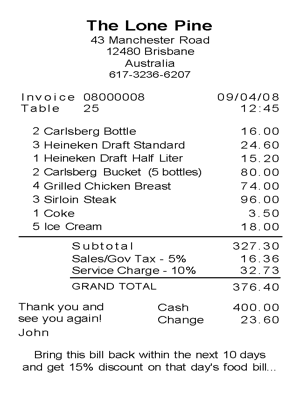

In [4]:
import urllib.request 
import numpy as np
from PIL import Image

# pull a random receipt image from internet
image_url='https://groups.google.com/group/jzebra-users/attach/d16dbba8a612edfa/Bill%20Image_Receipt.png?part=0.1'
local_image_id='bill_image_receipt.png'
urllib.request.urlretrieve(image_url,local_image_id) 
receipt_image = Image.open(local_image_id)
receipt_image_array = np.array(receipt_image.convert('RGB'))
display(receipt_image.resize((300,400)))

### 2. OCR Receipt Image

In [5]:
%%time
from paddleocr import PaddleOCR, draw_ocr
from ast import literal_eval
import json

paddleocr = PaddleOCR(lang="en",ocr_version="PP-OCRv4",show_log = False,use_gpu=True)

def paddle_scan(paddleocr,img_path_or_nparray):
    result = paddleocr.ocr(img_path_or_nparray,cls=True)
    result = result[0]
    boxes = [line[0] for line in result]       #boundign box 
    txts = [line[1][0] for line in result]     #raw text
    scores = [line[1][1] for line in result]   # scores
    return  txts, result

# perform ocr scan
receipt_texts, receipt_boxes = paddle_scan(paddleocr,receipt_image_array)
print(50*"--","\ntext only:\n",receipt_texts)
print(50*"--","\nocr boxes:\n",receipt_boxes)

---------------------------------------------------------------------------------------------------- 
text only:

[
    'The Lone Pine',
    '43 Manchester Road',
    '12480 Brisbane',
    'Australia',
    '617-3236-6207',
    'Invoice 08000008',
    '09/04/08',
    'Table',
    '25',
    '12:45',
    '2 Carlsberg Bottle',
    '16.00',
    '3 Heineken Draft Standard.',
    '24.60',
    '1 Heineken Draft Half Liter.',
    '15.20',
    '2 Carlsberg Bucket (5 bottles).',
    '80.00',
    '4 Grilled Chicken Breast.',
    '74.00',
    '3 Sirloin Steak',
    '96.00',
    '1 Coke',
    '3.50',
    '5 Ice Cream',
    '18.00',
    'Subtotal',
    '327.30',
    'Sales/Gov Tax - 5%',
    '16.36',
    'Service Charge - 10%',
    '32.73',
    'GRAND TOTAL',
    '376.40',
    'Thank you and',
    'Cash',
    '400.00',
    'see you again!',
    'Change',
    '23.60',
    'John',
    'Bring this bill back within the next 10 days',
    "and get 15% discount on that day's food bill.."
]

---------------------------------------------------------------------------------------------------- 
ocr boxes:

[
    [[[188.0, 54.0], [453.0, 54.0], [453.0, 85.0], [188.0, 85.0]], ('The Lone Pine', 0.9998102188110352)],
    [[[194.0, 96.0], [449.0, 98.0], [449.0, 122.0], [194.0, 120.0]], ('43 Manchester Road', 0.9988968372344971)],
    [[[228.0, 127.0], [416.0, 130.0], [416.0, 154.0], [228.0, 151.0]], ('12480 Brisbane', 0.9658010601997375)],
    [[[267.0, 162.0], [375.0, 162.0], [375.0, 186.0], [267.0, 186.0]], ('Australia', 0.9997145533561707)],
    [[[234.0, 193.0], [409.0, 193.0], [409.0, 216.0], [234.0, 216.0]], ('617-3236-6207', 0.9996874332427979)],
    [[[46.0, 255.0], [308.0, 255.0], [308.0, 278.0], [46.0, 278.0]], ('Invoice 08000008', 0.9919923543930054)],
    [[[466.0, 255.0], [598.0, 255.0], [598.0, 278.0], [466.0, 278.0]], ('09/04/08', 0.9994747042655945)],
    [[[42.0, 283.0], [132.0, 283.0], [132.0, 311.0], [42.0, 311.0]], ('Table', 0.9969210624694824)],
    [[[174.0, 283.0], [214.0, 283.0], [214.0, 311.0], [174.0, 311.0]], ('25', 0.9997891783714294)],
    [[[514.0, 284.0], [601.0, 284.0], [601.0, 311.0], [514.0, 311.0]], ('12:45', 0.9964954257011414)],
    [[[67.0, 346.0], [291.0, 349.0], [291.0, 376.0], [67.0, 374.0]], ('2 Carlsberg Bottle', 0.9987921118736267)],
    [[[515.0, 346.0], [599.0, 346.0], [599.0, 372.0], [515.0, 372.0]], ('16.00', 0.9999278783798218)],
    [
        [[69.0, 385.0], [395.0, 387.0], [395.0, 411.0], [69.0, 409.0]],
        ('3 Heineken Draft Standard.', 0.9832896590232849)
    ],
    [[[515.0, 384.0], [599.0, 384.0], [599.0, 409.0], [515.0, 409.0]], ('24.60', 0.9998160600662231)],
    [
        [[71.0, 423.0], [391.0, 423.0], [391.0, 446.0], [71.0, 446.0]],
        ('1 Heineken Draft Half Liter.', 0.9641079306602478)
    ],
    [[[515.0, 421.0], [601.0, 421.0], [601.0, 450.0], [515.0, 450.0]], ('15.20', 0.9998868703842163)],
    [
        [[69.0, 460.0], [430.0, 461.0], [430.0, 485.0], [69.0, 484.0]],
        ('2 Carlsberg Bucket (5 bottles).', 0.974445641040802)
    ],
    [[[515.0, 461.0], [599.0, 461.0], [599.0, 486.0], [515.0, 486.0]], ('80.00', 0.9999423027038574)],
    [
        [[69.0, 498.0], [367.0, 500.0], [367.0, 524.0], [69.0, 522.0]],
        ('4 Grilled Chicken Breast.', 0.9773013591766357)
    ],
    [[[515.0, 499.0], [599.0, 499.0], [599.0, 524.0], [515.0, 524.0]], ('74.00', 0.9999669194221497)],
    [[[68.0, 534.0], [250.0, 537.0], [250.0, 562.0], [68.0, 560.0]], ('3 Sirloin Steak', 0.9997309446334839)],
    [[[515.0, 537.0], [599.0, 537.0], [599.0, 561.0], [515.0, 561.0]], ('96.00', 0.9999544024467468)],
    [[[67.0, 571.0], [162.0, 574.0], [161.0, 601.0], [67.0, 598.0]], ('1 Coke', 0.9997830390930176)],
    [[[530.0, 572.0], [602.0, 572.0], [602.0, 601.0], [530.0, 601.0]], ('3.50', 0.9999455213546753)],
    [[[69.0, 609.0], [219.0, 613.0], [218.0, 638.0], [68.0, 634.0]], ('5 Ice Cream', 0.9914276003837585)],
    [[[516.0, 611.0], [599.0, 611.0], [599.0, 637.0], [516.0, 637.0]], ('18.00', 0.9999335408210754)],
    [[[154.0, 664.0], [288.0, 664.0], [288.0, 688.0], [154.0, 688.0]], ('Subtotal', 0.9990750551223755)],
    [[[499.0, 664.0], [599.0, 664.0], [599.0, 688.0], [499.0, 688.0]], ('327.30', 0.9999768137931824)],
    [
        [[155.0, 701.0], [397.0, 701.0], [397.0, 724.0], [155.0, 724.0]],
        ('Sales/Gov Tax - 5%', 0.9552016854286194)
    ],
    [[[514.0, 697.0], [601.0, 697.0], [601.0, 724.0], [514.0, 724.0]], ('16.36', 0.999823272228241)],
    [
        [[155.0, 733.0], [419.0, 733.0], [419.0, 757.0], [155.0, 757.0]],
        ('Service Charge - 10%', 0.9921379089355469)
    ],
    [[[512.0, 728.0], [601.0, 731.0], [600.0, 759.0], [511.0, 757.0]], ('32.73', 0.9999620318412781)],
    [[[154.0, 775.0], [335.0, 775.0], [335.0, 799.0], [154.0, 799.0]], ('GRAND TOTAL', 0.9899482131004333)],
    [[[499.0, 778.0], [599.0, 778.0], [599.0, 802.0], [499.0, 802.0]], ('376.40', 0.9999797940254211)],
    [[[39.0, 831.0], [223.0, 831.0], [223.0, 859.0], [39.0, 859.0]]

CPU times: user 2.49 s, sys: 863 ms, total: 3.35 s
Wall time: 3.34 s


### 3. Load Finetuned LLM Model

In [6]:
%%time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, BitsAndBytesConfig

# quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)
bnb_config = BitsAndBytesConfig(
    llm_int8_enable_fp32_cpu_offload=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
# control model memory allocation between devices for low GPU resource (0,cpu)
device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": 0,
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": 0,
    "model.layers":0,
    "model.norm":0    
}
device = "cuda" if torch.cuda.is_available() else "cpu"

# model use for inference
#model_id="mychen76/mistral7b_ocr_to_json_v1"
model_id="mychen76/mistral_ocr2json_v3_chatml"
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    trust_remote_code=True,  
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    device_map=device_map)
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 6.69 s, sys: 7.34 s, total: 14 s
Wall time: 14.9 s


In [7]:
#model.config

### 4. Run Inference

In [8]:
prompt=f"""<|im_start|>system
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into structure receipt data object. 
Don't make up value not in the Input. Output must be a well-formed JSON object.```json<|im_end|>
<|im_start|>user
{receipt_boxes}<|im_end|>
<|im_start|>assistant
"""

In [9]:
%%time
with torch.inference_mode():
    inputs = tokenizer(prompt,return_tensors="pt",truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=768,temperature=1) ##use_cache=True, do_sample=True,temperature=0.1, top_p=0.95
    result_text = tokenizer.batch_decode(outputs)[0]
    print(result_text)

# clear 
torch.cuda.empty_cache()

<s> <|im_start|>system
You are POS receipt data expert, parse, detect, recognize and convert following receipt OCR image result into 
structure receipt data object. 
Don't make up value not in the Input. Output must be a well-formed JSON object.```json<|im_end|>
<|im_start|>user
[[[[188.0, 54.0], [453.0, 54.0], [453.0, 85.0], [188.0, 85.0]], ('The Lone Pine', 0.9998102188110352)], [[[194.0, 
96.0], [449.0, 98.0], [449.0, 122.0], [194.0, 120.0]], ('43 Manchester Road', 0.9988968372344971)], [[[228.0, 
127.0], [416.0, 130.0], [416.0, 154.0], [228.0, 151.0]], ('12480 Brisbane', 0.9658010601997375)], [[[267.0, 162.0],
[375.0, 162.0], [375.0, 186.0], [267.0, 186.0]], ('Australia', 0.9997145533561707)], [[[234.0, 193.0], [409.0, 
193.0], [409.0, 216.0], [234.0, 216.0]], ('617-3236-6207', 0.9996874332427979)], [[[46.0, 255.0], [308.0, 255.0], 
[308.0, 278.0], [46.0, 278.0]], ('Invoice 08000008', 0.9919923543930054)], [[[466.0, 255.0], [598.0, 255.0], 
[598.0, 278.0], [466.0, 278.0]], ('09/04/08', 0.9994747042655945)], [[[42.0, 283.0], [132.0, 283.0], [132.0, 
311.0], [42.0, 311.0]], ('Table', 0.9969210624694824)], [[[174.0, 283.0], [214.0, 283.0], [214.0, 311.0], [174.0, 
311.0]], ('25', 0.9997891783714294)], [[[514.0, 284.0], [601.0, 284.0], [601.0, 311.0], [514.0, 311.0]], ('12:45', 
0.9964954257011414)], [[[67.0, 346.0], [291.0, 349.0], [291.0, 376.0], [67.0, 374.0]], ('2 Carlsberg Bottle', 
0.9987921118736267)], [[[515.0, 346.0], [599.0, 346.0], [599.0, 372.0], [515.0, 372.0]], ('16.00', 
0.9999278783798218)], [[[69.0, 385.0], [395.0, 387.0], [395.0, 411.0], [69.0, 409.0]], ('3 Heineken Draft 
Standard.', 0.9832896590232849)], [[[515.0, 384.0], [599.0, 384.0], [599.0, 409.0], [515.0, 409.0]], ('24.60', 
0.9998160600662231)], [[[71.0, 423.0], [391.0, 423.0], [391.0, 446.0], [71.0, 446.0]], ('1 Heineken Draft Half 
Liter.', 0.9641079306602478)], [[[515.0, 421.0], [601.0, 421.0], [601.0, 450.0], [515.0, 450.0]], ('15.20', 
0.9998868703842163)], [[[69.0, 460.0], [430.0, 461.0], [430.0, 485.0], [69.0, 484.0]], ('2 Carlsberg Bucket (5 
bottles).', 0.974445641040802)], [[[515.0, 461.0], [599.0, 461.0], [599.0, 486.0], [515.0, 486.0]], ('80.00', 
0.9999423027038574)], [[[69.0, 498.0], [367.0, 500.0], [367.0, 524.0], [69.0, 522.0]], ('4 Grilled Chicken 
Breast.', 0.9773013591766357)], [[[515.0, 499.0], [599.0, 499.0], [599.0, 524.0], [515.0, 524.0]], ('74.00', 
0.9999669194221497)], [[[68.0, 534.0], [250.0, 537.0], [250.0, 562.0], [68.0, 560.0]], ('3 Sirloin Steak', 
0.9997309446334839)], [[[515.0, 537.0], [599.0, 537.0], [599.0, 561.0], [515.0, 561.0]], ('96.00', 
0.9999544024467468)], [[[67.0, 571.0], [162.0, 574.0], [161.0, 601.0], [67.0, 598.0]], ('1 Coke', 
0.9997830390930176)], [[[530.0, 572.0], [602.0, 572.0], [602.0, 601.0], [530.0, 601.0]], ('3.50', 
0.9999455213546753)], [[[69.0, 609.0], [219.0, 613.0], [218.0, 638.0], [68.0, 634.0]], ('5 Ice Cream', 
0.9914276003837585)], [[[516.0, 611.0], [599.0, 611.0], [599.0, 637.0], [516.0, 637.0]], ('18.00', 
0.9999335408210754)], [[[154.0, 664.0], [288.0, 664.0], [288.0, 688.0], [154.0, 688.0]], ('Subtotal', 
0.9990750551223755)], [[[499.0, 664.0], [599.0, 664.0], [599.0, 688.0], [499.0, 688.0]], ('327.30', 
0.9999768137931824)], [[[155.0, 701.0], [397.0, 701.0], [397.0, 724.0], [155.0, 724.0]], ('Sales/Gov Tax - 5%', 
0.9552016854286194)], [[[514.0, 697.0], [601.0, 697.0], [601.0, 724.0], [514.0, 724.0]], ('16.36', 
0.999823272228241)], [[[155.0, 733.0], [419.0, 733.0], [419.0, 757.0], [155.0, 757.0]], ('Service Charge - 10%', 
0.9921379089355469)], [[[512.0, 728.0], [601.0, 731.0], [600.0, 759.0], [511.0, 757.0]], ('32.73', 
0.9999620318412781)], [[[154.0, 775.0], [335.0, 775.0], [335.0, 799.0], [154.0, 799.0]], ('GRAND TOTAL', 
0.9899482131004333)], [[[499.0, 778.0], [599.0, 778.0], [599.0, 802.0], [499.0, 802.0]], ('376.40', 
0.9999797940254211)], [[[0

CPU times: user 20.8 s, sys: 722 ms, total: 21.5 s
Wall time: 21.5 s


In [10]:
#result_text

### 5. View Result Json Object

In [11]:
# import json
# output_text = result_text.split("<|im_start|>assistant")
# output_text=output_text[1].split(",")
# if len(output_text)>1:
#     output_json=output_text[1]
# else:
#     output_json = output_text

# ## load out as json object
# #json.loads("".join(output_text))
# #x="".join(output_text)
# output_text

In [12]:
t1 = time.time()
total_time = t1-t0
print("took ",total_time)

took  42.16791081428528